<a href="https://colab.research.google.com/github/sirmammingtonham/projects/blob/main/hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In your project, you will pick an image dataset to solve a classification task. Provide a link to
your dataset.

I chose the pokemon image dataset, which provides the task of predicting a pokemon's type (e.g. water, grass, electric) from an image of the pokemon.

https://www.kaggle.com/vishalsubbiah/pokemon-images-and-types

In [1]:
%%capture
!unzip pokemon.zip

#Task 1 (70 points):
###Part 1 (20 points): 
This step involves downloading, preparing, and visualizing your
dataset. Create a convolutional base using a common pattern: a stack of Conv and
MaxPooling layers. Depending on the problem and the dataset you must decide what
pattern you want to use (i.e., how many Conv layers and how many pooling layers).
Please describe why you chose a particular pattern. Add the final dense layer(s).
Compile and train the model. Report the final evaluation and describe the metrics.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib
import shutil
import pandas as pd
import tensorflow as tf

In [3]:
data_dir = pathlib.Path('/content/images/images')

In [4]:
images = list(data_dir.glob('*'))

In [5]:
len(images) # dataset seems very small

809

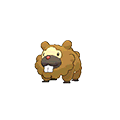

In [6]:
PIL.Image.open(str(images[0]))

In [7]:
df = pd.read_csv('pokemon.csv')

In [8]:
df = df.drop('Type2', axis=1)

In [9]:
df.head()

,Name,Type1
0,bulbasaur,Grass
1,ivysaur,Grass
2,venusaur,Grass
3,charmander,Fire
4,charmeleon,Fire


In [10]:
df.groupby('Type1').count()

,Name
Type1,
Bug,72
Dark,29
Dragon,27
Electric,40
Fairy,18
Fighting,29
Fire,53
Flying,3
Ghost,27


In [11]:
len(df.groupby('Type1').count())

18

In [12]:
images_map = {image.name[:-4]: image for image in images} # map pokemon name to file

In [13]:
!mkdir -p pokemon

In [14]:
# move images into respective folders so we can create dataset
for typing in df['Type1'].unique():
  new_dir = f'./pokemon/{typing}'
  os.makedirs(new_dir, exist_ok=True)
  files = [images_map[name] for name in df[df['Type1'] == typing]['Name']]
  for f in files:
    output = pathlib.Path(f'{new_dir}/{f.name}')
    shutil.move(f, output)

In [15]:
data_dir = pathlib.Path('/content/pokemon')

In [16]:
batch_size = 32
img_size = 128
SEED = 62030

In [36]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode='categorical',
  subset="training",
  seed=SEED,
  image_size=(img_size, img_size),
  batch_size=batch_size)

Found 809 files belonging to 18 classes.
Using 648 files for training.


In [37]:
class_names = train_ds.class_names

In [38]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  label_mode='categorical',
  subset="validation",
  seed=SEED,
  image_size=(img_size, img_size),
  batch_size=batch_size)

Found 809 files belonging to 18 classes.
Using 80 files for validation.


In [39]:
class_names

['Bug',
 'Dark',
 'Dragon',
 'Electric',
 'Fairy',
 'Fighting',
 'Fire',
 'Flying',
 'Ghost',
 'Grass',
 'Ground',
 'Ice',
 'Normal',
 'Poison',
 'Psychic',
 'Rock',
 'Steel',
 'Water']

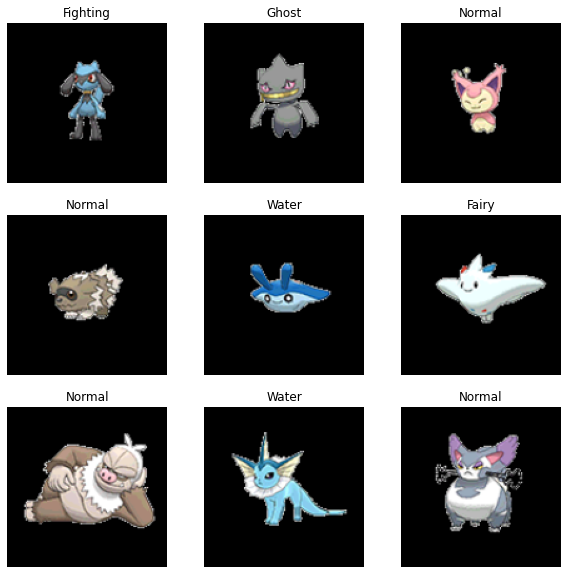

In [40]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")


In [41]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

In [42]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [43]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  # increase size of input
  tf.keras.layers.Resizing(256, 256, input_shape=(img_size, img_size, 3)),
  # conv layers
  tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(strides=2),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(strides=2),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(strides=2),
  # dense layers
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(num_classes)
])

In [44]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 256, 256, 8)       224       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 16)       

In [46]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
21/21 [==============================] - 2s 62ms/step - loss: 13.5743 - accuracy: 0.0463 - val_loss: 2.8480 - val_accuracy: 0.0417
Epoch 2/10
21/21 [==============================] - 1s 47ms/step - loss: 2.7729 - accuracy: 0.1265 - val_loss: 2.8343 - val_accuracy: 0.0833
Epoch 3/10
21/21 [==============================] - 1s 48ms/step - loss: 2.6038 - accuracy: 0.1775 - val_loss: 2.8243 - val_accuracy: 0.1250
Epoch 4/10
21/21 [==============================] - 1s 46ms/step - loss: 2.3121 - accuracy: 0.2469 - val_loss: 2.6777 - val_accuracy: 0.1875
Epoch 5/10
21/21 [==============================] - 1s 46ms/step - loss: 1.9456 - accuracy: 0.3997 - val_loss: 2.7363 - val_accuracy: 0.1458
Epoch 6/10
21/21 [==============================] - 1s 45ms/step - loss: 1.6049 - accuracy: 0.5031 - val_loss: 3.1876 - val_accuracy: 0.0833
Epoch 7/10
21/21 [==============================] - 1s 47ms/step - loss: 1.3270 - accuracy: 0.5694 - val_loss: 3.1319 - val_accuracy: 0.1250
Epoch 8/10
2

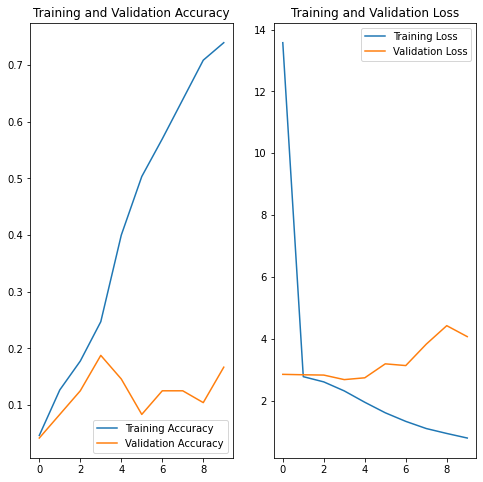

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [48]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

1/1 [==============================] - 0s 108ms/step - loss: 3.8636 - accuracy: 0.1562
Test accuracy : 0.15625


**ANSWER**: I chose an architecture with 3 conv layers and 3 pooling layers, then finally 3 dense layers. The architecture also includes a resizing layer to upscale the images (I hypothesized that this would help the model see the features of the pokemon, and this did help the model converge faster). For the conv layers, I kept the filter size at 3x3 since the image sizes are pretty small, and used a stride of 2 on the pooling layers. 

The EDA shows that this is actually a pretty difficult problem due to the small amount of training data and 18 possible classes.

As seen in the training graph, the model overfits really quickly and doesn't generalize well at all to the validation set. I evaulated the model's accuracy on the test set, and the performance is very poor, at around 12%. I believe this is an issue with the small dataset size and class imbalance, so data augmentation will most likely be very helpful for this problem.

###Part 2 (25 points): 
The following models are widely used for transfer learning because of
their performance and architectural innovations:
1. VGG (e.g., VGG16 or VGG19).
2. GoogLeNet (e.g., InceptionV3).
3. Residual Network (e.g., ResNet50).
4. MobileNet (e.g., MobileNetV2)

Choose any one of the above models to perform the classification task you did in Part 1.
Evaluate the results using the same metrics as in Part 1. Are there any differences? Why
or why not?

In [49]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(img_size, img_size, 3),
  include_top=False,
  weights='imagenet'
)

In [50]:
mobile_net.trainable = False

In [51]:
# mobile_net.summary()

In [52]:
inputs = tf.keras.Input(shape=(img_size, img_size, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = mobile_net(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes)(x)
model = tf.keras.Model(inputs, outputs)

In [53]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [54]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 128, 128, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 128, 128, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 18)                23058 

In [55]:
epochs = 30
history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds)

Epoch 1/30
21/21 [==============================] - 7s 120ms/step - loss: 3.9736 - accuracy: 0.0525 - val_loss: 3.0592 - val_accuracy: 0.1042
Epoch 2/30
21/21 [==============================] - 1s 39ms/step - loss: 3.4860 - accuracy: 0.0787 - val_loss: 2.8357 - val_accuracy: 0.0625
Epoch 3/30
21/21 [==============================] - 1s 39ms/step - loss: 3.2908 - accuracy: 0.0802 - val_loss: 2.8172 - val_accuracy: 0.1250
Epoch 4/30
21/21 [==============================] - 1s 39ms/step - loss: 3.1830 - accuracy: 0.1127 - val_loss: 2.9556 - val_accuracy: 0.1458
Epoch 5/30
21/21 [==============================] - 1s 38ms/step - loss: 3.0546 - accuracy: 0.1065 - val_loss: 2.6883 - val_accuracy: 0.1875
Epoch 6/30
21/21 [==============================] - 1s 38ms/step - loss: 3.0424 - accuracy: 0.1343 - val_loss: 2.7421 - val_accuracy: 0.1250
Epoch 7/30
21/21 [==============================] - 1s 39ms/step - loss: 2.9807 - accuracy: 0.1466 - val_loss: 2.6892 - val_accuracy: 0.1458
Epoch 8/30
2

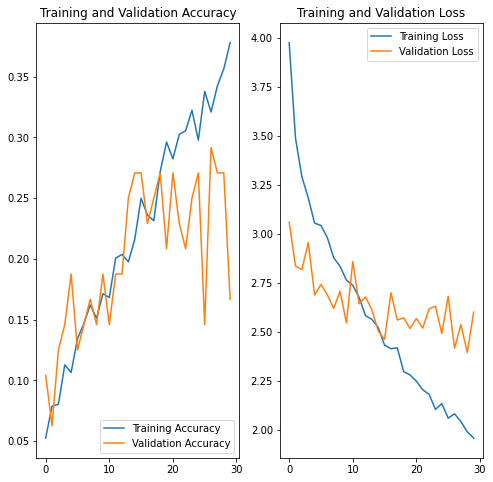

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [57]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

1/1 [==============================] - 0s 122ms/step - loss: 2.7500 - accuracy: 0.1562
Test accuracy : 0.15625


**ANSWER**: I used the mobilenet pretrained model and added a dense layer as the classification head. The model performs better than my architecture and is about 25% accurate on the test set. It seems to be overfitting less as shown in the graph, since the accuracy for both training and validation are more closely correlated than in my architecture

### Part 3 (25 points): 
Use data augmentation to increase the diversity of your dataset by
applying random transformations such as image rotation (you can use any other
technique as well). Repeat the process from part 1 with this augmented data. Did you
observe any difference in results?


In [60]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  # increase size of input
  tf.keras.layers.Resizing(256, 256, input_shape=(img_size, img_size, 3)),
  # flip
  tf.keras.layers.RandomFlip("horizontal"),
  # rotate
  tf.keras.layers.RandomRotation(0.1),
  # zoom
  tf.keras.layers.RandomZoom(0.3),
  # rescale
  tf.keras.layers.Rescaling(1./255),
  # conv layers
  tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(strides=2),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(strides=2),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(strides=2),
  # dense layers
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(num_classes)
])

In [61]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [62]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
21/21 [==============================] - 3s 73ms/step - loss: 2.8357 - accuracy: 0.1142 - val_loss: 2.7717 - val_accuracy: 0.1667
Epoch 2/30
21/21 [==============================] - 2s 57ms/step - loss: 2.7403 - accuracy: 0.1543 - val_loss: 2.6666 - val_accuracy: 0.2292
Epoch 3/30
21/21 [==============================] - 2s 58ms/step - loss: 2.6940 - accuracy: 0.1775 - val_loss: 2.6184 - val_accuracy: 0.3125
Epoch 4/30
21/21 [==============================] - 2s 58ms/step - loss: 2.6657 - accuracy: 0.1898 - val_loss: 2.5975 - val_accuracy: 0.2708
Epoch 5/30
21/21 [==============================] - 2s 58ms/step - loss: 2.6353 - accuracy: 0.2052 - val_loss: 2.7394 - val_accuracy: 0.1875
Epoch 6/30
21/21 [==============================] - 2s 58ms/step - loss: 2.5561 - accuracy: 0.2238 - val_loss: 2.7071 - val_accuracy: 0.1458
Epoch 7/30
21/21 [==============================] - 2s 59ms/step - loss: 2.5830 - accuracy: 0.2145 - val_loss: 2.6694 - val_accuracy: 0.2292
Epoch 8/30
21

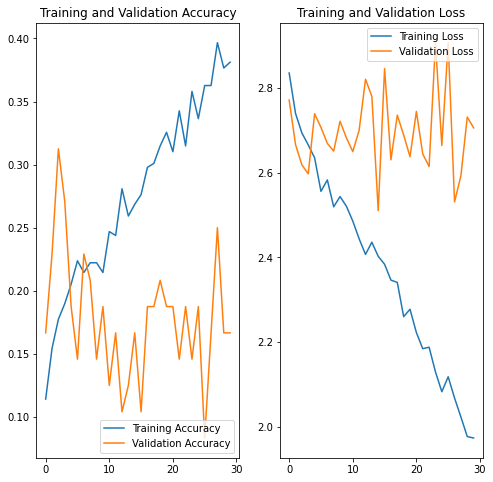

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [64]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

1/1 [==============================] - 0s 102ms/step - loss: 2.9154 - accuracy: 0.1250
Test accuracy : 0.125


**ANSWER**: The training accuracy did not increase as fast as in the model without data augmentation. However, the validation accuracy still remains low, so I believe that there is still a lot of overfitting despite all of the regularization and data augmentation. This is most likely because of the class imbalance and lack of data in this dataset.

#Task 2 (30 points):
###Part 1 (15 points): Variational Autoencoder (VAE): 
Here is a complete implementation
of a VAE in TensorFlow: https://www.tensorflow.org/tutorials/generative/cvae
Following these steps try generating images using the same encoder-decoder architecture using
a different Image dataset (other than MNIST).

In [65]:
train_images = np.concatenate([x for x, y in train_ds], axis=0)
test_images = np.concatenate([x for x, y in val_ds], axis=0)

In [66]:
def preprocess_images(images):
  images = images / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [67]:
train_size = 60000
batch_size = 32
test_size = 10000

In [68]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

In [69]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(img_size, img_size, 3)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=32*32*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(32, 32, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [70]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [71]:
epochs = 10
latent_dim = 200
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [72]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [73]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

In [74]:
import time
from IPython import display

In [75]:
epochs = 20

Epoch: 20, Test set ELBO: -9792.7392578125, time elapse for current epoch: 1.4612329006195068


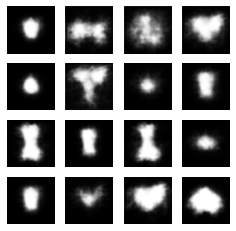

In [76]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

###Part 2 (15 points): 
Generative Adversarial Networks (GANs): Repeat part 1 (use same
dataset) and implement a GAN model to generate high quality synthetic images. You may
follow steps outlined here: https://www.tensorflow.org/tutorials/generative/dcgan


had to switch tutorials to https://learnopencv.com/deep-convolutional-gan-in-pytorch-and-tensorflow/#tensorflow

In [89]:
BATCH_SIZE = 32

In [90]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'pokemon',
  image_size=(img_size, img_size),
  batch_size=batch_size,
  label_mode=None)

Found 809 files belonging to 1 classes.


In [91]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

normalization_layer = tf.keras.layers.Rescaling(scale= 1./127.5, offset=-1)
normalized_ds = train_ds.map(lambda x: normalization_layer(x))

In [119]:
def generator():
    inputs = tf.keras.Input(shape=(1, 1, 200), name='input_layer')
    # Block 1:input is latent(100), going into a convolution
    x = tf.keras.layers.Conv2DTranspose(64 * 8, kernel_size=4, strides= 4, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_1')(inputs)
    x = tf.keras.layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1')(x)
    x = tf.keras.layers.ReLU(name='relu_1')(x)
    
    # Block 2: input is 4 x 4 x (64 * 8)
    x = tf.keras.layers.Conv2DTranspose(64 * 4, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_2')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2')(x)
    x = tf.keras.layers.ReLU(name='relu_2')(x)
    
    # Block 3: input is 8 x 8 x (64 * 4)
    x = tf.keras.layers.Conv2DTranspose(64 * 2, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_3')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_3')(x)
    x = tf.keras.layers.ReLU(name='relu_3')(x)
  
    # Block 4: input is 16 x 16 x (64 * 2)
    x = tf.keras.layers.Conv2DTranspose(64 * 1, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_4')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_4')(x)
    x = tf.keras.layers.ReLU(name='relu_4')(x)
    
    # Block 5: input is 32 x 32 x (64 * 1)
    x = tf.keras.layers.Conv2DTranspose(64 * 1, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_5')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_5')(x)
    x = tf.keras.layers.ReLU(name='relu_5')(x)

    outputs = tf.keras.layers.Conv2DTranspose(3, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, activation='tanh', name='conv_transpose_6')(x)
    # Output: output 64 x 64 x 3
    model = tf.keras.Model(inputs, outputs, name="Generator")
    return model

In [120]:
def discriminator():
    
    inputs = tf.keras.Input(shape=(img_size, img_size, 3), name='input_layer')
    # Block 1: input is 64 x 64 x (3)
    x = tf.keras.layers.Conv2D(64, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_1')(inputs)
    x = tf.keras.layers.LeakyReLU(0.2, name='leaky_relu_1')(x)
    
    # Block 2: input is 32 x 32 x (64)
    x = tf.keras.layers.Conv2D(64 * 2, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_2')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1')(x)
    x = tf.keras.layers.LeakyReLU(0.2, name='leaky_relu_2')(x)
    
    # Block 3: input is 16 x 16 x (64*2)
    x = tf.keras.layers.Conv2D(64 * 4, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_3')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2')(x)
    x = tf.keras.layers.LeakyReLU(0.2, name='leaky_relu_3')(x)
  
    # Block 4: input is 8 x 8 x (64*4)
    x = tf.keras.layers.Conv2D(64 * 8, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_4')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_3')(x)
    x = tf.keras.layers.LeakyReLU(0.2, name='leaky_relu_4')(x)
    
    # Block 5: input is 4 x 4 x (64*4)
    outputs = tf.keras.layers.Conv2D(1, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, activation='sigmoid', name='conv_5')(x)
    # Output: 1 x 1 x 1
    model = tf.keras.Model(inputs, outputs, name="Discriminator")
    return model

In [121]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

def generator_loss(label, fake_output):
    gen_loss = binary_cross_entropy(label, fake_output)
    return gen_loss

In [122]:
def discriminator_loss(label, output):
    disc_loss = binary_cross_entropy(label, output)
    return disc_loss

In [123]:
learning_rate = 0.0002
generator_optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )
discriminator_optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [124]:
generator = generator()
discriminator = discriminator()

In [128]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    # noise vector sampled from normal distribution
    noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])

    # Train Discriminator with real labels
    with tf.GradientTape() as disc_tape1:
        generated_images = generator(noise, training=True)

        
        real_output = discriminator(images, training=True)
        real_targets = tf.ones_like(real_output)
        disc_loss1 = discriminator_loss(real_targets, real_output)
        
    # gradient calculation for discriminator for real labels    
    gradients_of_disc1 = disc_tape1.gradient(disc_loss1, discriminator.trainable_variables)
    
    # parameters optimization for discriminator for real labels   
    discriminator_optimizer.apply_gradients(zip(gradients_of_disc1,\
    discriminator.trainable_variables))
    
    # Train Discriminator with fake labels
    with tf.GradientTape() as disc_tape2:
        fake_output = discriminator(generated_images, training=True)
        fake_targets = tf.zeros_like(fake_output)
        disc_loss2 = discriminator_loss(fake_targets, fake_output)
    # gradient calculation for discriminator for fake labels 
    gradients_of_disc2 = disc_tape2.gradient(disc_loss2, discriminator.trainable_variables)
    
    
    # parameters optimization for discriminator for fake labels        
    discriminator_optimizer.apply_gradients(zip(gradients_of_disc2,\
    discriminator.trainable_variables))
    
    # Train Generator with real labels
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)
        real_targets = tf.ones_like(fake_output)
        gen_loss = generator_loss(real_targets, fake_output)

    # gradient calculation for generator for real labels     
    gradients_of_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    # parameters optimization for generator for real labels
    generator_optimizer.apply_gradients(zip(gradients_of_gen,\
    generator.trainable_variables))    
    return gen_loss, disc_loss1, disc_loss2

In [152]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        pred = (predictions[i, :, :, :] +1 ) * 127.5
        pred = np.array(pred)  
        plt.imshow(pred.astype(np.uint8))
        plt.axis('off')

    # plt.savefig('dcgan/tf/images/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()

In [153]:
test_input = tf.random.normal([num_examples_to_generate, 1, 1, latent_dim])

In [154]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        D_loss_list, G_loss_list = [], []
        for image_batch in dataset:
            i += 1
            train_step(image_batch)
        print(epoch)        
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                              epoch + 1,
                              test_input)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                            epochs,
                            test_input)


In [155]:
normalized_ds = train_ds.map(lambda x: normalization_layer(x))

(16, 128, 128, 3)


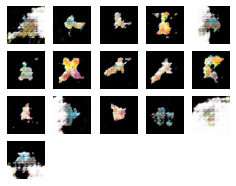

In [156]:
train(normalized_ds, 100)